In [20]:
import torch
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
# from sklearn.manifold import TSNE
import torch
import numpy as np
# from tqdm.notebook import tqdm  # Use notebook-friendly tqdm
import matplotlib.pyplot as plt
from argparse import Namespace
#from torch_geometric.explain import Explainer, GNNExplainer
import sys

sys.path.append('..')

# from src.explainability.gnn_explainer import GNNExplainer
# from main_transductive import pretrain
from src.utils import set_random_seed #, create_optimizer, WBLogger
from src.datasets.data_util import load_dataset, load_processed_graph
from src.models import build_model, PreModel
# from src.evaluation import node_classification_evaluation
# from src.utils import build_args, load_best_configs  # if needed
from src.explainability.gnn_explainer import GNNExplainer


In [3]:
# ----------------------
# Config settings
# ----------------------
# Choose device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Set seed for reproducibility
seed = 0
set_random_seed(seed)

In [4]:
# Define training hyperparameters
dataset_name    = "CPDB_cdgps" 
max_epoch       = 100           # Total training epochs
max_epoch_f     = 200           
num_hidden      = 64
num_layers      = 3
encoder_type    = "rgcn"     
decoder_type    = "rgcn"    
replace_rate    = 0.05
num_edge_types  = 6
in_drop         = 0.2
attn_drop       = 0.1
mask_rate       = 0.5
drop_edge_rate  = 0.0
alpha_l         = 3
num_heads       = 4
activation      = "prelu"          
optimizer       = "adam"            
loss_fn         = "sce"      
lr              = 0.01
weight_decay    = 1e-3
lr_f            = 0.005              
weight_decay_f  = 1e-4
linear_prob     = False
load_model      = False              # Set True to load a checkpoint
save_model      = True              # Set True to save trained model
logs            = True              # Set True to use WBLogger
use_scheduler   = True              # Set True to use a learning rate scheduler
weight_decomposition = {'type': 'basis', 'num_bases': 2}
vertical_stacking = True

In [5]:
# ----------------------
# Create a Namespace for Args
# ----------------------

args = Namespace(
    device         = device,
    seeds          = [seed],
    dataset        = dataset_name,
    max_epoch      = max_epoch,
    max_epoch_f    = max_epoch_f,
    num_hidden     = num_hidden,
    num_layers     = num_layers,
    encoder        = encoder_type,
    decoder        = decoder_type,
    activation     = activation,
    in_drop        = in_drop,
    attn_drop      = attn_drop,
    mask_rate      = mask_rate,
    drop_edge_rate = drop_edge_rate,
    alpha_l        = alpha_l,
    num_heads      = num_heads,
    weight_decomposition = weight_decomposition,
    vertical_stacking = vertical_stacking,
    replace_rate   = replace_rate,
    num_edge_types = num_edge_types,
    optimizer      = optimizer,
    loss_fn        = loss_fn,
    lr             = lr,
    weight_decay   = weight_decay,
    lr_f           = lr_f,
    weight_decay_f = weight_decay_f,
    linear_prob    = linear_prob,
    load_model     = load_model,
    save_model     = save_model,
    logging        = logs,
    scheduler      = use_scheduler,
    num_features   = 6, 
    num_out_heads  = 1,
    residual = False,
    norm = None,
    negative_slope = 0.2,
    concat_hidden = False,
    #return_hidden = False,
)

In [6]:
# ----------------------
# Load Dataset and Build Model
# ----------------------
# Load your graph from file.
graph = load_processed_graph(f'../data/real/multidim_graph/6d/{dataset_name}_multiomics.pt')
num_features = graph.x.shape[1]
num_classes = graph.y.max().item() + 1

args.num_features = num_features  
# (Optionally, you might add: args.num_classes = num_classes)

# Build and move model to device.
model = build_model(args)
model.to(device)

# Load the pretrained embedding (reconstruction) weights.
model.load_state_dict(torch.load('../checkpoints/emb_extraction_model.pt'))


<All keys matched successfully>

In [7]:
# ----------------------
# Reconfigure model for classification
# ----------------------
# Switch the model to classification mode by resetting its head.
# (If your model encapsulates the encoder under model.encoder, you might need:
#    model.encoder.reset_classifier(num_classes, concat=True, datas_dim=0)
# Otherwise, call it directly on the model.)
encoder = model.encoder
encoder.reset_classifier(num_classes, concat=True, datas_dim = 0)
# Now, when evaluating classification, the model will output logits with shape [num_nodes, num_classes]
# and no unwanted squeeze will occur.


In [8]:
print(graph.edge_index.shape)  # Should be: torch.Size([2, E])
print(graph.edge_type.shape)  # Should be: torch.Size([E])

torch.Size([2, 557288])
torch.Size([557288])


In [13]:
# ----------------------
# Explanation with GNNExplainer (using the classification head)
# ----------------------
node_idx = 20  # The node you want to explain

# Wrap your model with the modified GNNExplainer:
explainer = GNNExplainer(encoder, epochs=200, lr=0.01, num_hops=2)

# Get the explanation masks.
node_feat_mask, edge_mask = explainer.explain_node(node_idx, graph)

x_sub shape: torch.Size([6135, 64])
edge_index_sub shape: torch.Size([2, 369134])
mapping: tensor([15])
Out 1: tensor([[-0.0444],
        [-0.0447],
        [-0.0442],
        ...,
        [-0.0446],
        [-0.0498],
        [-0.0445]])
Out after extraction: tensor([[-0.0444],
        [-0.0447],
        [-0.0442],
        ...,
        [-0.0446],
        [-0.0498],
        [-0.0445]])
log_logits shape: torch.Size([6135, 1])
pred_label shape: torch.Size([6135])
Module is Instance of MessagePassing
Module is Instance of MessagePassing
Module is Instance of MessagePassing


Explain node 20: 100%|██████████| 200/200 [00:24<00:00,  8.15it/s]


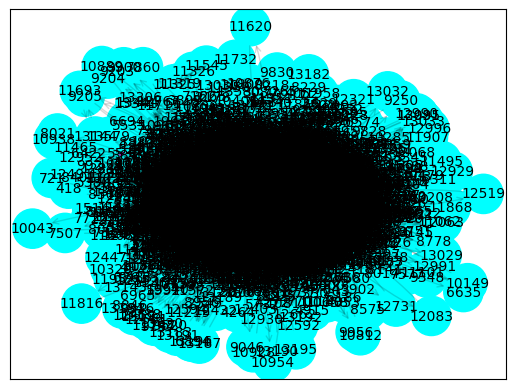

In [ ]:
# (You can then use the visualizer, e.g., explainer.visualize_subgraph, to inspect the subgraph.)
ax, G = explainer.visualize_subgraph(node_idx, graph.edge_index, edge_mask, y=graph.y)
plt.show()

In [15]:
import torch

K = 20
# full_edge_mask is a length-E Tensor of sigmoid-normalized scores in [0,1]
# get the indices of the top-K edges
topk = torch.topk(edge_mask, K).indices    # shape [K]
# extract their edge endpoints
topk_edges = graph.edge_index[:, topk]               # shape [2, K]

G = nx.Graph()
# add only the K edges
for u, v in topk_edges.t().tolist():
    G.add_edge(int(u), int(v))

In [44]:
pos = nx.spring_layout(G, seed=42, k=0.5)  # or kamada_kawai_layout, etc.
idx2gene = { i: name for i, name in enumerate(graph.name) }


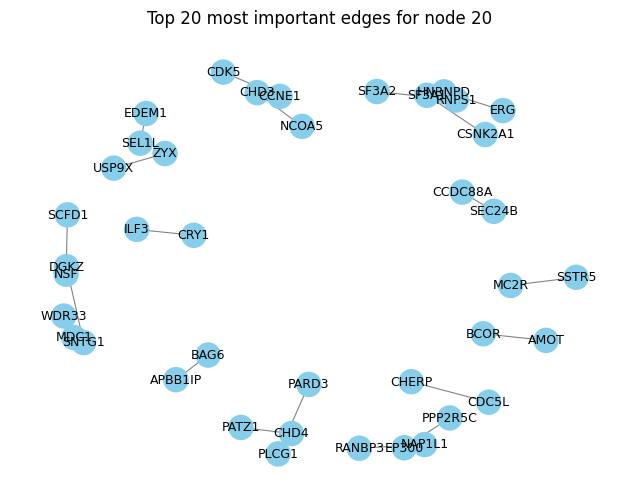

In [45]:
# node sizes: you could size them all equally, or proportional
node_sizes = [300 for _ in G.nodes()]

# edge widths: use the mask scores of those top-K edges
edge_scores = edge_mask[topk].cpu().numpy()
edge_widths = edge_scores * 5  # scale factor for visibility

plt.figure(figsize=(8,6))
nx.draw_networkx_nodes(G, pos,
                       node_size=node_sizes,
                       node_color='skyblue')
nx.draw_networkx_edges(G, pos,
                       width=edge_widths,
                       edge_color='gray')
nx.draw_networkx_labels(G, pos,
                       labels={n: idx2gene[n] for n in G.nodes()},
                       font_size=9)
plt.title(f"Top {K} most important edges for node {node_idx}")
plt.axis('off')
plt.show()

In [46]:
feature_names = ['MF: KIRC', 'MF: BRCA', 'MF: READ', 'MF: PRAD', 'MF: STAD',
       'MF: HNSC', 'MF: LUAD', 'MF: THCA', 'MF: BLCA', 'MF: ESCA',
       'MF: LIHC', 'MF: UCEC', 'MF: COAD', 'MF: LUSC', 'MF: CESC',
       'MF: KIRP', 'METH: KIRC', 'METH: BRCA', 'METH: READ',
       'METH: PRAD', 'METH: STAD', 'METH: HNSC', 'METH: LUAD',
       'METH: THCA', 'METH: BLCA', 'METH: ESCA', 'METH: LIHC',
       'METH: UCEC', 'METH: COAD', 'METH: LUSC', 'METH: CESC',
       'METH: KIRP', 'GE: KIRC', 'GE: BRCA', 'GE: READ', 'GE: PRAD',
       'GE: STAD', 'GE: HNSC', 'GE: LUAD', 'GE: THCA', 'GE: BLCA',
       'GE: ESCA', 'GE: LIHC', 'GE: UCEC', 'GE: COAD', 'GE: LUSC',
       'GE: CESC', 'GE: KIRP', 'CNA: KIRC', 'CNA: BRCA', 'CNA: READ',
       'CNA: PRAD', 'CNA: STAD', 'CNA: HNSC', 'CNA: LUAD',
       'CNA: THCA', 'CNA: BLCA', 'CNA: ESCA', 'CNA: LIHC',
       'CNA: UCEC', 'CNA: COAD', 'CNA: LUSC', 'CNA: CESC',
       'CNA: KIRP']

feat_imp = node_feat_mask.cpu().numpy()
feat_imp = np.squeeze(feat_imp)                     # now shape (F,)

# 2) Sanity check lengths:
assert feat_imp.shape[0] == len(feature_names), (
    f"mask length {feat_imp.shape[0]} vs names {len(feature_names)}"
)

df = pd.DataFrame({
    'feature': feature_names,   # e.g. ['expr', 'meth', 'mut', …]
    'importance': feat_imp
}).sort_values('importance', ascending=False)
print(df.head(10))

       feature  importance
7     MF: THCA    0.169461
16  METH: KIRC    0.155862
2     MF: READ    0.154509
28  METH: COAD    0.153928
22  METH: LUAD    0.153795
30  METH: CESC    0.153554
53   CNA: HNSC    0.152456
17  METH: BRCA    0.152283
46    GE: CESC    0.152045
19  METH: PRAD    0.150634
